In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from matplotlib.colors import to_rgb
from generativepy.color import Color
from PIL import ImageColor
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

In [35]:
names = locals()

In [2]:
China_provinces = gpd.read_file('../data/China-maps/province.shp')
China_boundary = gpd.read_file('../data/China-maps/boundary.shp')
China_counties = gpd.read_file('../data/China-maps/county.shp')
China_provinces2 = gpd.read_file('../data/China-maps-simplified/province.shp')
China_counties2 = gpd.read_file('../data/China-maps-simplified/county.shp')
China_provinces['geometry'] = China_provinces2['geometry']
China_counties['geometry'] = China_counties2['geometry']
China_counties = China_counties.drop([176, 638, 639, 2403])
China_counties = China_counties.reset_index(drop=True)

China_provinces = China_provinces.to_crs(2381)
China_boundary = China_boundary.to_crs(2381)
China_counties = China_counties.to_crs(2381)

In [28]:
matched_results = pd.read_csv('../outputs/matched_emissions_storage.csv', index_col=0)

In [31]:
China_counties['stored_CO2_2050_POP'] = matched_results['stored_CO2_2050_POP']
China_counties['stored_CO2_2050_GDP'] = matched_results['stored_CO2_2050_GDP']
China_counties['stored_CO2_2050_combined'] = matched_results['stored_CO2_2050_combined']

In [33]:
China_counties['weighted_distance_2050_POP'] = matched_results['weighted_distance_2050_POP']
China_counties['weighted_distance_2050_GDP'] = matched_results['weighted_distance_2050_GDP']
China_counties['weighted_distance_2050_combined'] = matched_results['weighted_distance_2050_combined']

In [26]:
match_results

,cum_CO2_2050_POP,cum_CO2_2050_GDP,cum_CO2_2050_combined,weighted_distance_2050_POP,weighted_distance_2050_GDP,weighted_distance_2050_combined,stored_CO2_2050_POP,stored_CO2_2050_GDP,stored_CO2_2050_combined
0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
1,33.3,8.2,25.3,336.573934,561.580000,378.638498,33.3,8.2,25.3
2,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
3,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
4,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2868,87.4,88.5,88.5,797.533181,776.024475,735.951706,87.4,88.5,88.5
2869,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
2870,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
2871,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0


In [15]:
county_shortest_distances = pd.read_csv('../data/shortest_distances_matrix.csv', index_col=0)
county_shortest_distances = county_shortest_distances.drop([176, 638, 639, 2403])
county_shortest_distances = county_shortest_distances.drop(['176', '638', '639', '2403'], axis=1)
county_distance_matrix = county_shortest_distances.values

In [6]:
storage_matrix_2030_POP = pd.read_csv('../outputs/storage_matrix_2030_POP.csv', index_col=0)
storage_matrix_2030_GDP = pd.read_csv('../outputs/storage_matrix_2030_GDP.csv', index_col=0)
storage_matrix_2030_combined = pd.read_csv('../outputs/storage_matrix_2030_combined.csv', index_col=0)

In [7]:
storage_matrix_2040_POP = pd.read_csv('../outputs/storage_matrix_2040_POP.csv', index_col=0)
storage_matrix_2040_GDP = pd.read_csv('../outputs/storage_matrix_2040_GDP.csv', index_col=0)
storage_matrix_2040_combined = pd.read_csv('../outputs/storage_matrix_2040_combined.csv', index_col=0)

In [8]:
storage_matrix_2050_POP = pd.read_csv('../outputs/storage_matrix_2050_POP.csv', index_col=0)
storage_matrix_2050_GDP = pd.read_csv('../outputs/storage_matrix_2050_GDP.csv', index_col=0)
storage_matrix_2050_combined = pd.read_csv('../outputs/storage_matrix_2050_combined.csv', index_col=0)

In [3]:
def hex_to_Color(hexcode):
    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v/256 for v in rgb]
    rgb = Color(*rgb)
    return rgb

In [9]:
def make_colorlist(c00_, c01_, c10_, c11_, num_grps):
    ### get corner colors from https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
    c00 = hex_to_Color(c00_)
    c10 = hex_to_Color(c10_)
    c01 = hex_to_Color(c01_)
    c11 = hex_to_Color(c11_)
    
    ### now create square grid of colors, using color interpolation from generativepy package
    c00_to_c10 = []
    c01_to_c11 = []
    colorlist = []
    for i in range(num_grps):
        c00_to_c10.append(c00.lerp(c10, 1/(num_grps-1) * i))
        c01_to_c11.append(c01.lerp(c11, 1/(num_grps-1) * i))
    for i in range(num_grps):
        for j in range(num_grps):
            colorlist.append(c00_to_c10[i].lerp(c01_to_c11[i], 1/(num_grps-1) * j))
    
    ### convert back to hex color
    colorlist = [rgb2hex([c.r, c.g, c.b]) for c in colorlist]

    return colorlist

In [10]:
def display_colorlist(colorlist, axx):
    # Create a matrix visualization
    num_grps = int(np.sqrt(len(colorlist)))
    # Set limits to create a grid
    axx.set_aspect('equal')
    axx.set_xlim(0, num_grps)
    axx.set_ylim(0, num_grps)

    for i in range(num_grps):
        for j in range(num_grps):
            index = i * num_grps + j
            color = colorlist[i * num_grps + j]
            rect = plt.Rectangle([j, i], 1, 1, color=color)  # Flip the vertical axxis
            axx.add_patch(rect)
            # axx.text(j + 0.5, i + 0.5, f'({index+1}) {color}', ha='center', va='center',
            #         color='black' if np.mean(to_rgb(color)) > 0.5 else 'white', fontsize=9, weight='bold')

    axx.axis('off')
    return axx

In [11]:
colorlist_1 = make_colorlist('#e8e8e8', '#64acbe', '#c85a5a', '#574249', 4)
colorlist_2 = make_colorlist('#e8e8e8', '#5ac8c8', '#be64ac', '#3b4994', 4)
colorlist_3 = make_colorlist('#e8e8e8', '#6c83b5', '#73ae80', '#2a5a5b', 4)
colorlist_4 = make_colorlist('#e8e8e8', '#c8b35a', '#9972af', '#804d36', 4)
colorlist_5 = make_colorlist('#EDE7F2', '#5AA5DC', '#CD595C', '#631676', 4)

In [12]:
values = [i+1 for i in range(16)]
custom_cmap1 = LinearSegmentedColormap.from_list('custom_cmap1', colorlist_1)
custom_cmap2 = LinearSegmentedColormap.from_list('custom_cmap2', colorlist_2)
custom_cmap3 = LinearSegmentedColormap.from_list('custom_cmap3', colorlist_3)
custom_cmap4 = LinearSegmentedColormap.from_list('custom_cmap4', colorlist_4)
custom_cmap5 = LinearSegmentedColormap.from_list('custom_cmap5', colorlist_5)

In [17]:
def find_gg(storage_matrix):
    aa = np.where(storage_matrix.values.astype(float) > 0, county_distance_matrix, 0)
    bb = np.where(storage_matrix.values.astype(float) > 0, storage_matrix.values, 0)
    cc = (aa * bb).astype(float)
    dd = cc.sum(axis=0)
    ee = bb.sum(axis=0)
    ff = dd / np.where(ee == 0, np.nan, ee) 
    gg = bb.sum(axis=0).astype(float)

    county_location = np.where(gg > 0)[0] 
    county_idx = China_counties['县代码'].values[county_location]

    y = gg[gg > 0]
    x = ff[gg > 0]

    df = pd.DataFrame([], index=county_idx, dtype=float) 
    df['x'] = x 
    df['y'] = y 

    return df 

In [18]:
xy_2030_POP = find_gg(storage_matrix_2030_POP)
xy_2040_POP = find_gg(storage_matrix_2040_POP)
xy_2050_POP = find_gg(storage_matrix_2050_POP)

xy_2030_GDP = find_gg(storage_matrix_2030_GDP)
xy_2040_GDP = find_gg(storage_matrix_2040_GDP)
xy_2050_GDP = find_gg(storage_matrix_2050_GDP)

xy_2030_combined = find_gg(storage_matrix_2030_combined)
xy_2040_combined = find_gg(storage_matrix_2040_combined)
xy_2050_combined = find_gg(storage_matrix_2050_combined)

In [46]:
the_max = 400
the_max_2050_1 = np.max(xy_2050_POP.sort_values(by='y')['y'].values)
the_max_2050_2 = np.max(xy_2050_GDP.sort_values(by='y')['y'].values)
the_max_2050_3 = np.max(xy_2050_combined.sort_values(by='y')['y'].values)
the_max_2050 = np.max([the_max_2050_1, the_max_2050_2, the_max_2050_3])
angles_2050_POP = 2 * np.pi * xy_2050_POP.sort_values(by='y')['y'].values / the_max
angles_2050_GDP = 2 * np.pi * xy_2050_GDP.sort_values(by='y')['y'].values / the_max
angles_2050_combined = 2 * np.pi * xy_2050_combined.sort_values(by='y')['y'].values / the_max

In [47]:
for scenario in ['POP', 'GDP', 'combined']:
    x = China_counties[f'stored_CO2_2050_{scenario}'].values.astype(float)
    y = China_counties[f'weighted_distance_2050_{scenario}'].values.astype(float)

    x_edges = np.quantile(x[x > 0], [0.25, 0.5, 0.75])
    x_edges = np.flip(x_edges)
    y_edges = np.quantile(y[y > 0], [0.25, 0.5, 0.75])

    # 获取每个数据点的区间索引（0-3）
    x_indices = np.digitize(x, x_edges)
    y_indices = np.digitize(y, y_edges)

    # 计算唯一区间编号（1-16）
    names[f'bin_numbers_{scenario}_'] = x_indices * 4 + y_indices + 1
    names[f'bin_numbers_{scenario}'] = names[f'bin_numbers_{scenario}_'].astype(np.float64)
    names[f'bin_numbers_{scenario}'][~(x > 0)] = np.nan

    China_counties[f'groups_{scenario}'] = names[f'bin_numbers_{scenario}']

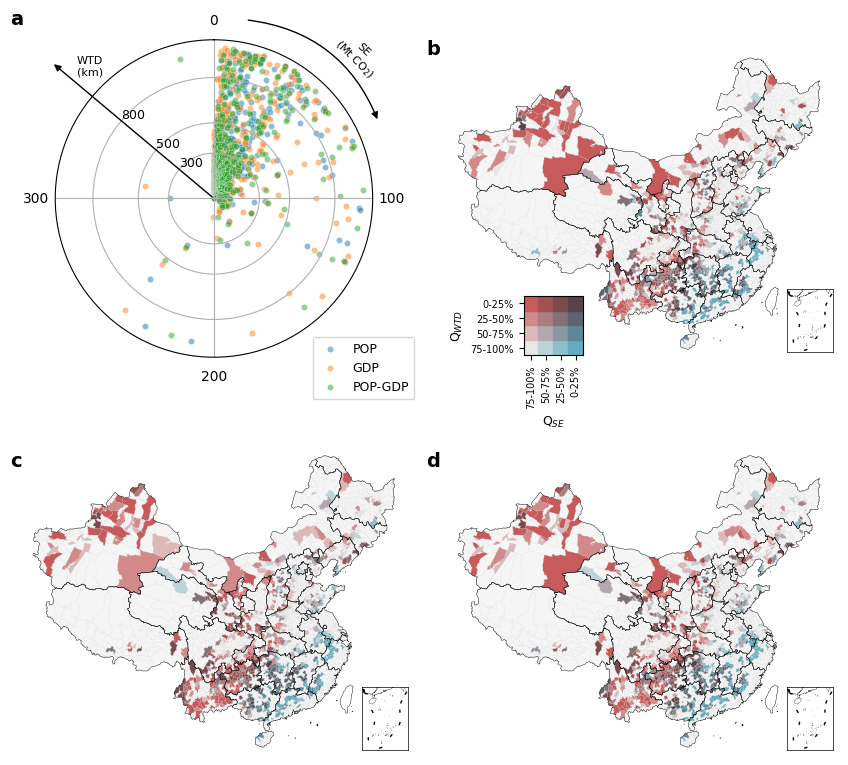

In [48]:
fig = plt.figure(figsize=(8.5, 7.5), constrained_layout=True)

for i, scenario in enumerate(['POP', 'GDP', 'combined']):
    ax1 = plt.subplot(2, 2, i+2) 
    China_counties.plot(
        column=f'groups_{scenario}',
        # norm=norm_1,
        cmap=custom_cmap1, 
        lw=0.1, 
        edgecolor='lightgrey',
        zorder=4, 
        ax=ax1,
        )
    China_provinces.plot(color='none', edgecolor='k', lw=0.3, zorder=5, ax=ax1)
    China_counties.plot(color='whitesmoke', edgecolor='lightgrey', lw=0.1, zorder=1, ax=ax1)
    ax1.set(ylim=(1.9*10**6, 6.3*10**6))
    ax1.axis('off')

    if i == 0:
        cax1 = ax1.inset_axes([0.21, 0.00, 0.15, 0.2])
        cax1.set_aspect('equal')
        num_grps = 4
        cax1.set_xlim(0, num_grps)
        cax1.set_ylim(0, num_grps)
        for i in range(num_grps):
            for j in range(num_grps):
                index = i * num_grps + j
                color = colorlist_1[i * num_grps + j]
                rect = plt.Rectangle([j, i], 1, 1, color=color)  # Flip the vertical axis
                cax1.add_patch(rect)

        cax1.set_xticks([0.5, 1.5, 2.5, 3.5])
        # cax1.set_xticklabels(['0-25%', '25-50%', '50-75%', '75-100%'], fontsize=7, rotation=45)
        cax1.set_xticklabels(['75-100%', '50-75%', '25-50%', '0-25%'], fontsize=7, rotation=90)
        cax1.set_yticks([0.5, 1.5, 2.5, 3.5])
        # cax1.set_yticklabels(['0-25%', '25-50%', '50-75%', '75-100%'], fontsize=7)
        cax1.set_yticklabels(['75-100%', '50-75%', '25-50%', '0-25%'], fontsize=7)
        cax1.set_ylabel('Q$_{WTD}$', fontsize=9)
        cax1.set_xlabel('Q$_{SE}$', fontsize=9)

    cax2 = ax1.inset_axes([0.87, 0.015, 0.12, 0.20])
    China_provinces.plot(color='none', lw=0.2, ax=cax2)
    China_boundary.plot(color='k', edgecolor='k', lw=1.0, ax=cax2)
    cax2.spines[:].set_linewidth(.5)
    cax2.set(xlim=(0.3*10**6, 2.0*10**6), ylim=(0.3*10**6, 2.65*10**6), xticks=[], yticks=[])

ax4 = plt.subplot(2, 2, 1, projection='polar')
sns.scatterplot(x=angles_2050_POP, y=xy_2050_POP.sort_values(by='y')['x'].values, alpha=0.5, s=20, label='POP', ax=ax4)
sns.scatterplot(x=angles_2050_GDP, y=xy_2050_GDP.sort_values(by='y')['x'].values, alpha=0.5, s=20, label='GDP', ax=ax4)
sns.scatterplot(x=angles_2050_combined, y=xy_2050_combined.sort_values(by='y')['x'].values, alpha=0.5, s=20, label='POP-GDP', ax=ax4)
ax4.set(
        xlim=(0, 2*np.pi), 
        xticks=[0, 1*np.pi/2, np.pi, 3*np.pi/2], 
        xticklabels=[0, round(1*the_max/4), round(the_max/2), round(3*the_max/4)], 
        yticks=[300, 500, 800]
        )
ax4.set_theta_zero_location('N')
ax4.set_theta_direction(-1)
arrow_3_1 = FancyArrowPatch((np.radians(10), 1200), (np.radians(65), 1200), connectionstyle="arc3,rad=-0.3", color="k", arrowstyle='-|>', mutation_scale=10,  lw=1, clip_on=False)
arrow_3_2 = FancyArrowPatch((np.radians(10), 0), (np.radians(-50), 1400), color="k", arrowstyle='-|>', mutation_scale=10,  lw=1, clip_on=False, zorder=5)
ax4.add_patch(arrow_3_1)
ax4.add_patch(arrow_3_2)
ax4.set_rlabel_position(-50) 
ax4.set_yticklabels([300, 500, 800], fontsize=9)
ax4.text(np.radians(-43), 1200, 'WTD\n(km)', fontsize=8, ha='center', va='center')
ax4.text(np.radians(45), 1350, 'SE\n(Mt CO$_{2}$)', fontsize=8, ha='center', va='center', rotation=-45)
ax4.legend(loc='lower right', fontsize=9, bbox_to_anchor=(1.15, -0.15))

fig.text(0.01, 0.98, 'a', fontsize=14, fontdict={'weight': 'semibold'})
fig.text(0.50, 0.94, 'b', fontsize=14, fontdict={'weight': 'semibold'})
fig.text(0.01, 0.39, 'c', fontsize=14, fontdict={'weight': 'semibold'})
fig.text(0.50, 0.39, 'd', fontsize=14, fontdict={'weight': 'semibold'})

plt.show()

In [49]:
fig.savefig('../figures/Fig_9.jpg', dpi=600, bbox_inches='tight')